# Analytic Methods

This book has focused on computational methods like simulation and resampling, but some of the problems we solved have analytic solutions that can be much faster.

This chapter presents some of these methods and explains how they work.
At the end of the chapter, I make suggestions for integrating computational and analytic methods for data analysis.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap14.ipynb).

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Normal Probability Plots

Many analytic methods are based on the properties of the normal distribution, for two reasons: distributions of many measurements in the real world are well-approximated by normal distributions, and normal distributions have mathematical properties that make them useful for analysis.

To demonstrate the first point, we'll look at some of the measurements in the penguin dataset, which we saw in Section XXX.
Then we'll explore the mathematical properties of the normal distribution.
Instructions for downloading the penguin dataset are in the notebook for this chapter.


The following cell downloads the data.

In [5]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

<IPython.core.display.Javascript object>

We can read the data like this.

In [6]:
penguins = pd.read_csv("penguins_raw.csv")
penguins.shape

(344, 17)

<IPython.core.display.Javascript object>

The datasets contain measurements from three penguin species.
For this example, we'll select the Adelie penguins.

In [7]:
adelie = penguins.query('Species.str.startswith("Adelie")').copy()
len(adelie)

152

<IPython.core.display.Javascript object>

To see if the penguin weights follow a normal distribution, we'll compute the empirical CDF of the data.

In [253]:
from empiricaldist import Cdf

weights = adelie["Body Mass (g)"].dropna()
cdf_weights = Cdf.from_seq(weights)

<IPython.core.display.Javascript object>

And we'll compute the analytic CDF of a normal distribution with the same mean and standard deviation.

In [254]:
m, s = np.mean(weights), np.std(weights)
m, s

(3700.662251655629, 457.04517271224495)

<IPython.core.display.Javascript object>

In [255]:
from scipy.stats import norm

dist = norm(m, s)
qs = np.linspace(m - 3.5 * s, m + 3.5 * s)
ps = dist.cdf(qs)

<IPython.core.display.Javascript object>

Here's what the CDF of the data looks like compared to the normal model.

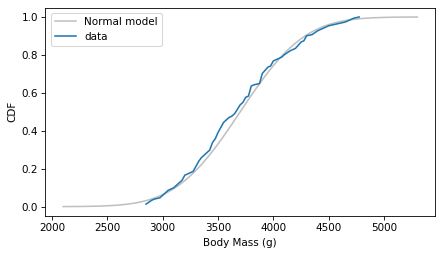

<IPython.core.display.Javascript object>

In [256]:
plt.plot(qs, ps, color="gray", alpha=0.5, label="Normal model")
cdf_weights.plot(label="data")

decorate(ylabel="CDF")

The normal distribution might be a good enough model of this data, but it's certainly not a perfect fit.

In general, plotting the CDF of the data and the CDF of a model is a good way to evaluate how well the model fits the data.
But one drawback of this method is that it depends on how well we estimate the parameters of the model -- in this example the mean and standard deviation.

An alternative is a normal probability plot, which does not depend on our ability to estimate parameters.
A normal probability plot is a kind of "P-P plot", which stands for **percentile-percentile plot**, because it plots the percentiles of the data against the percentiles of a model.
In a normal probability plot, the model is a standard normal distribution -- that is, one with mean 0 and standard deviation 1.

In a normal probability plot the $y$ values are the sorted measurements.

In [257]:
ys = np.sort(weights)

<IPython.core.display.Javascript object>

And the $x$ values are the corresponding percentiles of a normal distribution, computes using the `ppf` method of the `norm` object, which computes the inverse CDF.

In [258]:
n = len(weights)
xs = norm.ppf((np.arange(n) + 0.5) / n)

<IPython.core.display.Javascript object>

If the measurements are actually drawn from a normal distribution, the $y$ and $x$ values should fall on a straight line.
To see how well they do, we can use `linregress` to fit a line.

In [263]:
from scipy.stats import linregress

results = linregress(xs, ys)
intercept, slope = results.intercept, results.slope

fit_xs = np.linspace(-3, 3)
fit_ys = intercept + slope * fit_xs

<IPython.core.display.Javascript object>

Here are the results along with the fitted line.

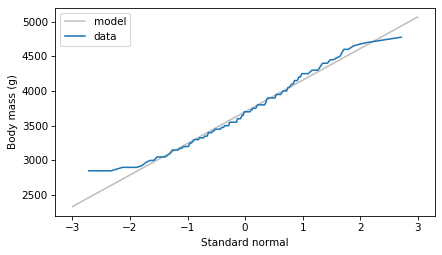

<IPython.core.display.Javascript object>

In [264]:
plt.plot(fit_xs, fit_ys, color="gray", alpha=0.5, label="model")
plt.plot(xs, ys, label="data")

decorate(xlabel="Standard normal", ylabel="Body mass (g)")

The normal probability plot is not a perfectly straight line, which indicates that the normal distribution is not a perfect model for this data.
One reason is that the dataset includes male and female penguins, so let's see what happens if we plot the two groups separately.
The following function encapsulates the steps we used to make a normal probability plot.


In [16]:
def normal_probability_plot(sample, **options):
    """Makes a normal probability plot with a fitted line."""
    n = len(sample)
    xs = norm.ppf((np.arange(n) + 0.5) / n)
    ys = np.sort(sample)

    results = linregress(xs, ys)
    intercept, slope = results.intercept, results.slope

    fit_xs = np.linspace(-3, 3)
    fit_ys = intercept + slope * fit_xs

    plt.plot(fit_xs, fit_ys, color="gray", alpha=0.5)
    plt.plot(xs, ys, **options)
    decorate(xlabel="Standard normal")

<IPython.core.display.Javascript object>

Here's what the results look like for male and female penguins.

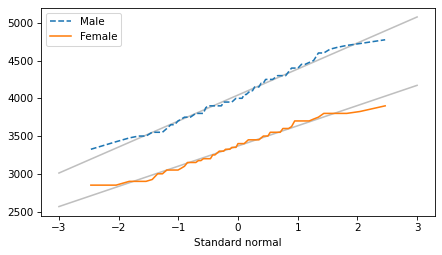

<IPython.core.display.Javascript object>

In [267]:
grouped = adelie.groupby("Sex")

weights_male = grouped.get_group("MALE")["Body Mass (g)"]
normal_probability_plot(weights_male, ls="--", label="Male")

weights_female = grouped.get_group("FEMALE")["Body Mass (g)"]
normal_probability_plot(weights_female, label="Female")

The normal probability plots for both groups are close to a straight line, which indicates that the distributions of weight follow normal distributions.
When we put the groups together, the distribution of their weights is a mixture of two normal distributions with different means -- and a mixture like that is not always well modeled by a normal distribution.

Now let's consider some of the mathematical properties of a normal distribution that make them so useful for analysis.

## Normal Distributions

In [18]:
class Normal:
    """Represents a Normal distribution"""

    def __init__(self, mu, sigma2):
        """Make a Normal object.

        mu: mean
        sigma2: variance
        """
        self.mu = mu
        self.sigma2 = sigma2

    def __repr__(self):
        """Returns a string representation."""
        return f"Normal({self.mu}, {self.sigma2})"

    __str__ = __repr__

<IPython.core.display.Javascript object>

In [19]:
m, s = np.mean(weights_male), np.std(weights_male)
dist_male = Normal(m, s**2)
dist_male

Normal(4043.4931506849316, 118630.60611747044)

<IPython.core.display.Javascript object>

In [20]:
m, s = np.mean(weights_female), np.std(weights_female)
dist_female = Normal(m, s**2)
dist_female

Normal(3368.8356164383563, 71571.58941640082)

<IPython.core.display.Javascript object>

In [21]:
%%add_method_to Normal

def sample(self, n):
    """Generate a random sample from this distribution."""
    sigma = np.sqrt(self.sigma2)
    return np.random.normal(self.mu, sigma, n)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

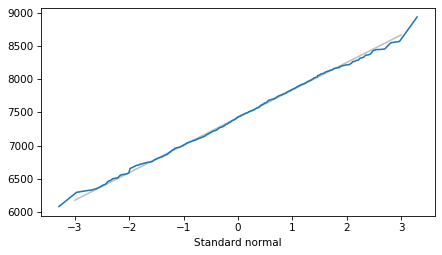

<IPython.core.display.Javascript object>

In [22]:
sample_sum = dist_male.sample(1000) + dist_female.sample(1000)
normal_probability_plot(sample_sum)

In [23]:
%%add_method_to Normal


def __add__(self, other):
    """Adds a number or other Normal.

    other: number or Normal

    returns: new Normal
    """
    if isinstance(other, Normal):
        return Normal(self.mu + other.mu, self.sigma2 + other.sigma2)
    else:
        return Normal(self.mu + other, self.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
dist_sum = dist_male + dist_female
dist_sum

Normal(7412.328767123288, 190202.19553387124)

<IPython.core.display.Javascript object>

In [25]:
%%add_method_to Normal


def plot_cdf(self, n_sigmas=4, **options):
    """Plot the CDF of this distribution."""
    mu, sigma = self.mu, np.sqrt(self.sigma2)
    low, high = mu - n_sigmas * sigma, mu + 3 * sigma
    xs = np.linspace(low, high, 101)
    ys = norm.cdf(xs, mu, sigma)
    plt.plot(xs, ys, **options)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

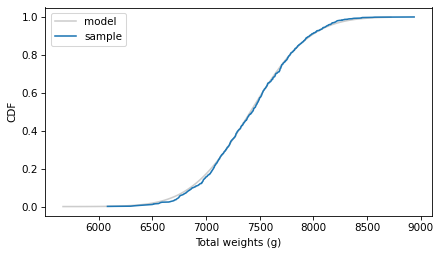

<IPython.core.display.Javascript object>

In [26]:
dist_sum.plot_cdf(color="gray", alpha=0.4, label="model")
Cdf.from_seq(sample_sum).plot(label="sample")

decorate(xlabel="Total weights (g)", ylabel="CDF")

In [27]:
n = len(weights_male)
sample_sums_male = [dist_male.sample(n).sum() for i in range(1001)]
n

73

<IPython.core.display.Javascript object>

In [28]:
%%add_method_to Normal


def sum(self, n):
    """Return the distribution of the sum of n values."""
    return Normal(n * self.mu, n * self.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
dist_sums_male = dist_male.sum(n)

<IPython.core.display.Javascript object>

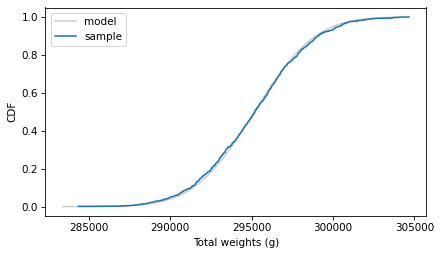

<IPython.core.display.Javascript object>

In [30]:
model_options = dict(color="gray", alpha=0.4, label="model")

dist_sums_male.plot_cdf(**model_options)
Cdf.from_seq(sample_sums_male).plot(label="sample")

decorate(xlabel="Total weights (g)", ylabel="CDF")

In [31]:
%%add_method_to Normal


def __mul__(self, factor):
    """Multiplies by a scalar."""
    return Normal(factor * self.mu, factor**2 * self.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
%%add_method_to Normal


def __truediv__(self, factor):
    """Multiplies by a scalar."""
    return self * (1/factor)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
dist_mean_male = dist_sums_male / n
sample_means_male = np.array(sample_sums_male) / n

<IPython.core.display.Javascript object>

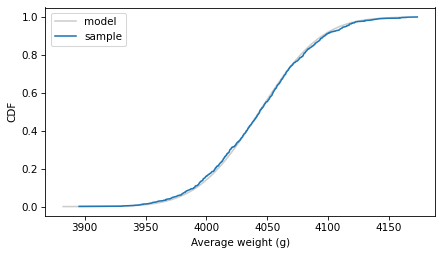

<IPython.core.display.Javascript object>

In [36]:
dist_mean_male.plot_cdf(**model_options)
Cdf.from_seq(sample_means_male).plot(label="sample")

decorate(xlabel="Average weight (g)", ylabel="CDF")

In [38]:
standard_error = np.sqrt(dist_mean_male.sigma2)
standard_error

40.31224126899585

<IPython.core.display.Javascript object>

In [39]:
standard_error = np.std(weights_male) / np.sqrt(n)
standard_error

40.31224126899585

<IPython.core.display.Javascript object>

In [40]:
n = len(weights_female)
dist_mean_female = dist_female.sum(n) * (1 / n)
dist_mean_female

Normal(3368.835616438356, 980.4327317315181)

<IPython.core.display.Javascript object>

In [41]:
%%add_method_to Normal

def __sub__(self, other):
    """Compute the distribution of a difference."""
    return Normal(self.mu - other.mu, self.sigma2 + other.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
dist_diff_means = dist_mean_male - dist_mean_female
dist_diff_means

Normal(674.6575342465753, 2605.50952786125)

<IPython.core.display.Javascript object>

In [43]:
sample_sums_female = [dist_female.sample(n).sum() for i in range(1001)]
sample_means_female = np.array(sample_sums_female) / n

<IPython.core.display.Javascript object>

In [44]:
sample_diff_means = sample_means_male - sample_means_female

<IPython.core.display.Javascript object>

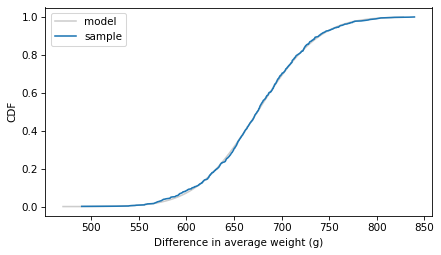

<IPython.core.display.Javascript object>

In [45]:
dist_diff_means.plot_cdf(**model_options)
Cdf.from_seq(sample_diff_means).plot(label="sample")

decorate(xlabel="Difference in average weight (g)", ylabel="CDF")

In [224]:
%%add_method_to Normal

def ppf(self, xs):
    sigma = np.sqrt(self.sigma2)
    return norm.ppf(xs, self.mu, sigma)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [226]:
ci90 = dist_diff_means.ppf([0.05, 0.95])
ci90

array([590.69731005, 758.61775845])

<IPython.core.display.Javascript object>

But that only works if the distribution of measurements is normal.
Or does it???

## Central Limit Theorem

As we saw in the previous sections, if we add values drawn from normal distributions, the distribution of the sum is normal.
Most other distributions don't have this property; if we add values drawn from other distributions, the sum does not generally have an analytic distribution.

But if we add up `n` values from almost any distribution, the distribution of the sum converges to normal as `n` increases.

More specifically, if the distribution of the values has mean and standard deviation $\mu$ and $\sigma$, the distribution of the sum is approximately $`Normal`(n \mu, n \sigma^2)$.

This result is the Central Limit Theorem (CLT).
It is one of the most useful tools for statistical analysis, but it comes with caveats:

-   The values have to be drawn independently.
If they are correlated, the CLT doesn't apply (although this is seldom a problem in practice).

-   The values have to come from the same distribution (although this requirement can be relaxed).

-   The values have to be drawn from a distribution with finite mean and variance.
So most Pareto distributions are out.

-   The rate of convergence depends on the skewness of the distribution.
Sums from an exponential distribution converge for small `n`.
Sums from a lognormal distribution require larger sizes.

The Central Limit Theorem explains the prevalence of normal distributions in the natural world.
Many characteristics of living things are affected by genetic and environmental factors whose effect is additive.
The characteristics we measure are the sum of a large number of small effects, so their distribution tends to be normal.

## Testing the CLT

To see how the Central Limit Theorem works, and when it doesn't, let's try some experiments.
First, we'll try an exponential distribution:

In [56]:
lam = 0.5
sample_map = {}
for n in [1, 10, 100]:
    sample_map[n] = [np.sum(np.random.exponential(1 / lam, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

`make_expo_samples` generates samples of sums of exponential values (I use "exponential values" as shorthand for "values from an exponential distribution").
`beta` is the parameter of the distribution; `iters` is the number of sums to generate.

To explain this function, I'll start from the inside and work my way out.
Each time we call `np.random.exponential`, we get a sequence of `n` exponential values and compute its sum.
`sample` is a list of these sums, with length `iters`.

It is easy to get `n` and `iters` confused: `n` is the number of terms in each sum; `iters` is the number of sums we compute in order to characterize the distribution of sums.

The return value is a list of `(n, sample)` pairs.
For each pair, we make a normal probability plot:

In [57]:
for n, sample in sample_map.items():
    print(n, np.mean(sample))

1 2.0233237123433163
10 20.118262912552865
100 200.43440782833866


<IPython.core.display.Javascript object>

In [58]:
def normal_plot_samples(samples, ylabel=""):
    """Makes normal probability plots for samples.

    samples: map from n to sample
    label: string
    """
    plt.figure(figsize=(8, 3.5))
    for i, n in enumerate(sample_map):
        plt.subplot(1, 3, i + 1)
        normal_probability_plot(sample_map[n])
        decorate(
            title="n=%d" % n,
            xticks=[],
            yticks=[],
            xlabel="Standard normal",
            ylabel=ylabel,
        )

<IPython.core.display.Javascript object>

`normal_plot_samples` takes the list of pairs from `make_expo_samples` and generates a row of normal probability plots.

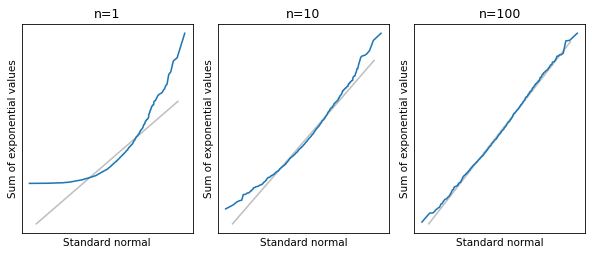

<IPython.core.display.Javascript object>

In [59]:
normal_plot_samples(sample_map, ylabel="Sum of exponential values")

With `n=1`, the distribution of the sum is exponential, so the normal probability plot is not a straight line.
But with `n=10` the distribution of the sum is approximately normal, and with `n=100` it is all but indistinguishable from normal.

The following shows similar results for a lognormal distribution.
Lognormal distributions are generally more skewed than exponential distributions, so the distribution of sums takes longer to converge.
With `n=10` the normal probability plot is nowhere near straight, but with `n=100` it is approximately normal.

In [60]:
mu, sigma = 1.0, 1.0
sample_map = {}
for n in [1, 10, 100]:
    sample_map[n] = [np.sum(np.random.lognormal(mu, sigma, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

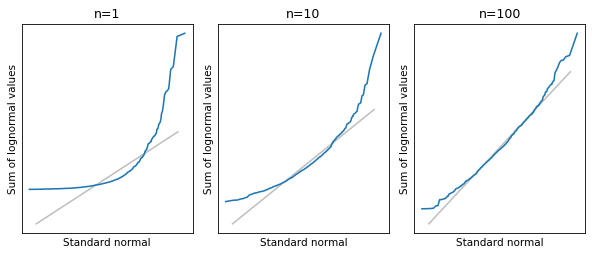

<IPython.core.display.Javascript object>

In [61]:
normal_plot_samples(sample_map, ylabel="Sum of lognormal values")

Pareto distributions are even more skewed than lognormal.
Depending on the parameters, many Pareto distributions do not have finite mean and variance.
As a result, the Central Limit Theorem does not apply.
Figure [\[normal2\]](#normal2){reference-type="ref" reference="normal2"} (top row) shows distributions of sums of Pareto values.
Even with `n=100` the normal probability plot is far from straight.

In [62]:
alpha = 1.0
sample_map = {}
for n in [1, 10, 100]:
    sample_map[n] = [np.sum(np.random.pareto(alpha, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

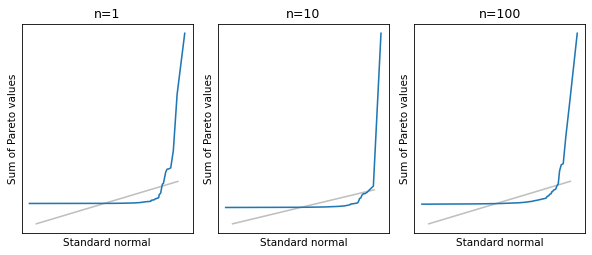

<IPython.core.display.Javascript object>

In [63]:
normal_plot_samples(sample_map, ylabel="Sum of Pareto values")

## Correlated Samples

I also mentioned that CLT does not apply if the values are correlated.
To test that, I generate correlated values from an exponential distribution.
The algorithm for generating correlated values is (1) generate correlated normal values, (2) use the normal CDF to transform the values to uniform, and (3) use the inverse exponential CDF to transform the uniform values to exponential.

`generate_correlated` returns an iterator of `n` normal values with serial correlation `rho`:

In [64]:
def generate_normal_correlated(rho, n):
    """Generates an array of correlated values from a standard normal dist."""
    xs = np.empty(n)
    xs[0] = np.random.normal(0, 1)

    sigma = np.sqrt(1 - rho**2)
    for i in range(1, n):
        xs[i] = rho * xs[i - 1] + np.random.normal(0, sigma)

    return xs

<IPython.core.display.Javascript object>

The first value is a standard normal value.
Each subsequent value depends on its predecessor: if the previous value is `x`, the mean of the next value is `x*rho`, with variance `1-rho**2`.
Note that `random.gauss` takes the standard deviation as the second argument, not variance.

`generate_expo_correlated` takes the resulting sequence and transforms it to exponential:

In [65]:
from scipy.stats import expon


def generate_expo_correlated(rho, n):
    """Generates a sequence of correlated values from an exponential dist."""
    normal = generate_normal_correlated(rho, n)
    uniform = norm.cdf(normal)
    expo = expon.ppf(uniform)
    return expo

<IPython.core.display.Javascript object>

`normal` is a list of correlated normal values.
`uniform` is a sequence of uniform values between 0 and 1. `expo` is a correlated sequence of exponential values.
`ppf` stands for "percent point function," which is another name for the inverse CDF.

In [66]:
rho = 0.6
sample_map = {}
for n in [1, 10, 100]:
    sample_map[n] = [np.sum(generate_expo_correlated(rho, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

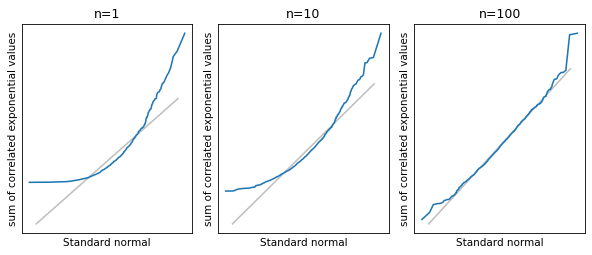

<IPython.core.display.Javascript object>

In [67]:
normal_plot_samples(sample_map, ylabel="sum of correlated exponential values")

These experiments are meant to show how the Central Limit Theorem works, and what happens when it doesn't.
Now let's see how we can use it.

## Applying the CLT

To see why the Central Limit Theorem is useful, let's get back to the example in Section XXX: testing the apparent difference in mean pregnancy length for first babies and others.
As we've seen, the apparent difference is about 0.078 weeks:

In [68]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [69]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

In [70]:
delta = firsts["prglngth"].mean() - others["prglngth"].mean()
delta

0.07803726677754952

<IPython.core.display.Javascript object>

Remember the logic of hypothesis testing: we compute a p-value, which is the probability of the observed difference under the null hypothesis; if it is small, we conclude that the observed difference is unlikely to be due to chance.

In this example, the null hypothesis is that the distribution of pregnancy lengths is the same for first babies and others.
So we can compute the sampling distribution of the mean like this:

In [72]:
def sampling_dist_mean(data, n):
    """Computes the sampling distribution of the mean.

    data: sequence of values representing the population
    n: sample size

    returns: Normal object
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.sum(n) * (1 / n)

<IPython.core.display.Javascript object>

In [76]:
dist1 = sampling_dist_mean(live.prglngth, len(firsts))
dist1

Normal(38.56055968517709, 0.0016548067228250207)

<IPython.core.display.Javascript object>

In [77]:
dist2 = sampling_dist_mean(live.prglngth, len(others))
dist2

Normal(38.56055968517709, 0.0015422728759929918)

<IPython.core.display.Javascript object>

Both sampling distributions are based on the same population, which is the pool of all live births.
`SamplingDistMean` takes this sequence of values and the sample size, and returns a `Normal` object representing the sampling distribution:

`mean` and `var` are the mean and variance of `data`.
We approximate the distribution of the data with a normal distribution, `dist`.

In this example, the data are not normally distributed, so this approximation is not very good.
But then we compute `dist.Sum(n) / n`, which is the sampling distribution of the mean of `n` values.
Even if the data are not normally distributed, the sampling distribution of the mean is, by the Central Limit Theorem.

Next, we compute the sampling distribution of the difference in the means.
The `Normal` class knows how to perform subtraction using Equation 2:

So we can compute the sampling distribution of the difference like this:

In [78]:
dist_diff = dist1 - dist2
dist_diff

Normal(0.0, 0.0031970795988180128)

<IPython.core.display.Javascript object>

In [79]:
%%add_method_to Normal

def cdf(self, xs):
    sigma = np.sqrt(self.sigma2)
    return norm.cdf(xs, self.mu, sigma)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The mean is 0, which makes sense because we expect two samples from the same distribution to have the same mean, on average.
The variance of the sampling distribution is 0.0032.

`Normal` provides `Prob`, which evaluates the normal CDF.
We can use `Prob` to compute the probability of a difference as large as `delta` under the null hypothesis:

In [80]:
1 - dist_diff.cdf(delta)

0.08377070425543787

<IPython.core.display.Javascript object>

Which means that the p-value for a one-sided test is 0.084.
For a two-sided test we would also compute

In [81]:
dist_diff.cdf(-delta)

0.08377070425543781

<IPython.core.display.Javascript object>

Which is the same because the normal distribution is symmetric.
The sum of the tails is 0.168, which is consistent with the estimate in Section XXX, which was 0.17.

## Correlation test

In Section xxx we used a permutation test for the correlation between birth weight and mother's age, and found that it is statistically significant, with p-value less than 0.001.

Now we can do the same thing analytically.
The method is based on this mathematical result: given two variables that are normally distributed and uncorrelated, if we generate a sample with size $n$, compute Pearson's correlation, $r$, and then compute the transformed correlation $$t = r \sqrt{\frac{n-2}{1-r^2}}$$ the distribution of $t$ is Student's t-distribution with parameter $n-2$.
The t-distribution is an analytic distribution; the CDF can be computed efficiently using gamma functions.

To get from `ts` to the correlation coefficients, `rs`, we apply the inverse transform, 

$$r = t / \sqrt{n - 2 + t^2}$$ 

The result is the sampling distribution of $r$ under the null hypothesis.

The following figure shows this distribution along with the distribution we generated by resampling.
They are nearly identical.
Although the actual distributions are not normal, Pearson's coefficient of correlation is based on sample means and variances.
By the Central Limit Theorem, these moment-based statistics are normally distributed even if the data are not.

In [82]:
from scipy.stats import t as student_t


def student_cdf(n):
    """Computes the CDF correlations from uncorrelated variables.

    n: sample size

    returns: Cdf
    """
    ts = np.linspace(-3, 3, 101)
    ps = student_t.cdf(ts, df=n - 2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return Cdf(ps, rs)

<IPython.core.display.Javascript object>

In [130]:
def generate_data(n):
    xs = np.random.normal(0, 1, n)
    ys = np.random.normal(0, 1, n)
    return xs, ys

<IPython.core.display.Javascript object>

In [129]:
def correlation(data):
    xs, ys = data
    return np.corrcoef(xs, ys)[0, 1]

<IPython.core.display.Javascript object>

In [132]:
correlation(generate_data(n))

0.007100358174045357

<IPython.core.display.Javascript object>

In [133]:
corrs = [correlation(generate_data(n)) for i in range(1001)]
cdf_corrs = Cdf.from_seq(corrs)

<IPython.core.display.Javascript object>

We can use this result to compute the sampling distribution of correlation under the null hypothesis; that is, if we generate uncorrelated sequences of normal values, what is the distribution of their correlation? `student_cdf` takes the sample size, `n`, and returns the sampling distribution of correlation:

`ts` is a NumPy array of values for $t$, the transformed correlation.
`ps` contains the corresponding probabilities, computed using the CDF of the Student's t-distribution implemented in SciPy.
The parameter of the t-distribution, `df`, stands for "degrees of freedom." I won't explain that term, but you can read about it at <http://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics)>.

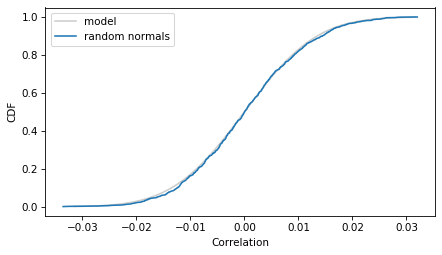

<IPython.core.display.Javascript object>

In [134]:
student_cdf(n).plot(**model_options)
cdf_corrs.plot(label="random normals")

decorate(xlabel="Correlation", ylabel="CDF")

In [171]:
valid = live.dropna(subset=["agepreg", "totalwgt_lb"])
n = len(valid)
n

9038

<IPython.core.display.Javascript object>

In [172]:
data = valid["agepreg"].values, valid["totalwgt_lb"].values
r_actual = correlation(data)
r_actual

0.0688339703541091

<IPython.core.display.Javascript object>

In [173]:
def permute(data):
    """Shuffle the x values."""
    xs, ys = data
    new_xs = xs.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

<IPython.core.display.Javascript object>

In [176]:
permuted_corrs = [correlation(permute(data)) for i in range(1001)]
cdf_permuted = Cdf.from_seq(permuted_corrs)

<IPython.core.display.Javascript object>

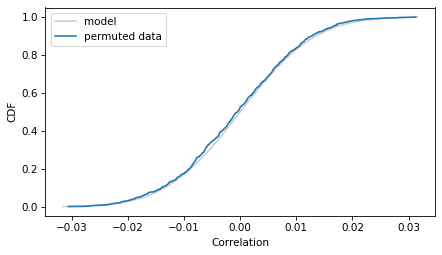

<IPython.core.display.Javascript object>

In [177]:
student_cdf(n).plot(**model_options)
cdf_permuted.plot(label="permuted data")

decorate(xlabel="Correlation", ylabel="CDF")

We can see that the observed correlation, 0.07, is unlikely to occur if the variables are actually uncorrelated.
Using the analytic distribution, we can compute just how unlikely:

In [178]:
t = r_actual * np.sqrt((n - 2) / (1 - r_actual**2))
p_value = 1 - student_t.cdf(t, df=n - 2)
p_value

2.861466619208386e-11

<IPython.core.display.Javascript object>

In [179]:
p_value * 2

5.722933238416772e-11

<IPython.core.display.Javascript object>

In [180]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(*data)
p_value

5.722947107314431e-11

<IPython.core.display.Javascript object>

We compute the value of `t` that corresponds to `r=0.07`, and then evaluate the t-distribution at `t`.
The result is `2.9e-11`.
This example demonstrates an advantage of the analytic method: we can compute very small p-values.
But in practice it usually doesn't matter.

## Chi-squared test

In Section XXX we used the chi-squared statistic to test whether a die is crooked.
The chi-squared statistic measures the total normalized deviation from the expected values in a table:

$$\chi^2 = \sum_i \frac{{(O_i - E_i)}^2}{E_i}$$ 

One reason the chi-squared statistic is widely used is that its sampling distribution under the null hypothesis is analytic; by a remarkable coincidence (not really), it is called the chi-squared distribution.
Like the t-distribution, the chi-squared CDF can be computed efficiently using gamma functions.

In [181]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed.index.name = "outcome"
observed

,freqs
outcome,
1,8
2,9
3,19
4,5
5,8
6,11


<IPython.core.display.Javascript object>

In [182]:
def chi_squared_stat(observed):
    n = observed.sum()
    outcomes = observed.qs
    expected = Hist(n / 6, outcomes)
    diffs = (observed - expected) ** 2
    return sum((observed - expected) ** 2 / expected)

<IPython.core.display.Javascript object>

In [193]:
observed_chi2 = chi_squared_stat(observed)
observed_chi2

11.6

<IPython.core.display.Javascript object>

The following figure shows the analytic result along with the distribution we got by resampling.
They are very similar, especially in the tail, which is the part we usually care most about.

We can use this distribution to compute the p-value of the observed test statistic, `chi2`:

In [194]:
def simulate_dice(observed):
    n = np.sum(observed)
    rolls = np.random.choice(observed.qs, n, replace=True)
    hist = Hist.from_seq(rolls)
    return hist

<IPython.core.display.Javascript object>

In [195]:
simulated_chi_squared = [chi_squared_stat(simulate_dice(observed)) for i in range(1001)]
cdf_simulated = Cdf.from_seq(simulated_chi_squared)

<IPython.core.display.Javascript object>

SciPy provides an implementation of the chi-squared distribution, which we use to compute the sampling distribution of the chi-squared statistic:

In [196]:
from scipy.stats import chi2 as chi2_dist


def chi_squared_cdf(n):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size

    returns: Cdf
    """
    xs = np.linspace(0, 25, 101)
    ps = chi2_dist.cdf(xs, df=n - 1)
    return Cdf(ps, xs)

<IPython.core.display.Javascript object>

In [197]:
n = len(observed)
cdf_model = chi_squared_cdf(n)

<IPython.core.display.Javascript object>

<Axes: >

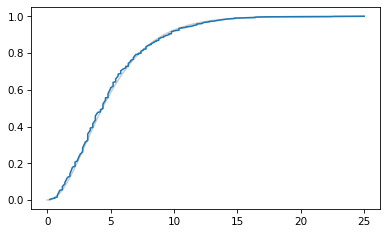

<IPython.core.display.Javascript object>

In [198]:
cdf_model.plot(**model_options)
cdf_simulated.plot(label="simulation")

In [199]:
p_value = 1 - chi2_dist.cdf(observed_chi2, df=n - 1)
p_value

0.04069938850404997

<IPython.core.display.Javascript object>

In [203]:
observed

,freqs
outcome,
1,8
2,9
3,19
4,5
5,8
6,11


<IPython.core.display.Javascript object>

In [210]:
from empiricaldist import Pmf

n = observed.sum()
outcomes = observed.qs
expected = Pmf(n / 6, outcomes)

<IPython.core.display.Javascript object>

In [211]:
from scipy.stats import chisquare

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
chi2_stat

11.6

<IPython.core.display.Javascript object>

In [212]:
p_value

0.040699388504049985

<IPython.core.display.Javascript object>

The result is 0.041, which is consistent with the result from resampling.

The parameter of the chi-squared distribution is "degrees of freedom" again.
In this case the correct parameter is `n-1`, where `n` is the size of the table, 6. Choosing this parameter can be tricky; to be honest, I am never confident that I have it right until I generate something like the previous figure to compare the analytic results to the resampling results.

## Discussion

This book focuses on computational methods like resampling and permutation.
These methods have several advantages over analysis:

-   They are easier to explain and understand.
For example, one of the most difficult topics in an introductory statistics class is hypothesis testing.
Many students don't really understand what p-values are.
I think the approach I presented in Chapter [\[testing\]](#testing){reference-type="ref" reference="testing"}---simulating the null hypothesis and computing test statistics---makes the fundamental idea clearer.

-   They are robust and versatile.
Analytic methods are often based on assumptions that might not hold in practice.
Computational methods require fewer assumptions, and can be adapted and extended more easily.

-   They are debuggable.
Analytic methods are often like a black box: you plug in numbers and they spit out results.
But it's easy to make subtle errors, hard to be confident that the results are right, and hard to find the problem if they are not.
Computational methods lend themselves to incremental development and testing, which fosters confidence in the results.

But there is one drawback: computational methods can be slow.
Taking into account these pros and cons, I recommend the following process:

1.  Use computational methods during exploration.
If you find a satisfactory answer and the run time is acceptable, you can stop.

2.  If run time is not acceptable, look for opportunities to optimize.
Using analytic methods is one of several methods of optimization.

3.  If replacing a computational method with an analytic method is appropriate, use the computational method as a basis of comparison, providing mutual validation between the computational and analytic results.

For the vast majority of problems I have worked on, I didn't have to go past Step 1.

## Exercises

**Exercise:**    In Section 5.4, we saw that the distribution of adult weights is approximately lognormal.
One possible explanation is that the weight a person gains each year is proportional to their current weight.
In that case, adult weight is the product of a large number of multiplicative factors:

w = w0 f1 f2 ... fn  

where w is adult weight, w0 is birth weight, and fi is the weight gain factor for year i.

The log of a product is the sum of the logs of the factors:

logw = logw0 + logf1 + logf2 + ... + logfn 

So by the Central Limit Theorem, the distribution of logw is approximately normal for large n, which implies that the distribution of w is lognormal.

To model this phenomenon, choose a distribution for f that seems reasonable, then generate a sample of adult weights by choosing a random value from the distribution of birth weights, choosing a sequence of factors from the distribution of f, and computing the product.
What value of n is needed to converge to a lognormal distribution?

In [216]:
def generate_adult_weight(birth_weights, n):
    """Generate a random adult weight by simulating annual gain.

    birth_weights: sequence of birth weights in lbs
    n: number of years to simulate

    returns: adult weight in lbs
    """
    bw = np.random.choice(birth_weights)
    factors = np.random.normal(1.09, 0.03, n)
    aw = bw * np.prod(factors)
    return aw

<IPython.core.display.Javascript object>

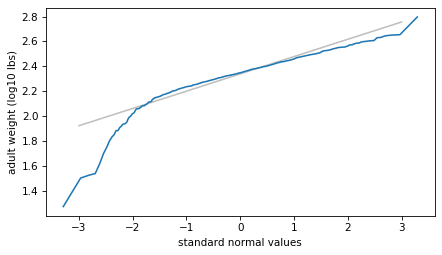

<IPython.core.display.Javascript object>

In [219]:
birth_weights = live.totalwgt_lb.dropna().values
aws = [generate_adult_weight(birth_weights, 40) for _ in range(1000)]
log_aws = np.log10(aws)
normal_probability_plot(log_aws)
decorate(
    xlabel="standard normal values",
    ylabel="adult weight (log10 lbs)",
)

**Exercise:** In Section 14.6 we used the Central Limit Theorem to find the sampling distribution of the difference in means, δ, under the null hypothesis that both samples are drawn from the same population.

We can also use this distribution to find the standard error of the estimate and confidence intervals, but that would only be approximately correct.
To be more precise, we should compute the sampling distribution of δ under the alternate hypothesis that the samples are drawn from different populations.

Compute this distribution and use it to calculate the standard error and a 90% confidence interval for the difference in means.

In [220]:
# Solution

delta = firsts["prglngth"].mean() - others["prglngth"].mean()
print(delta)

0.07803726677754952


<IPython.core.display.Javascript object>

In [222]:
# Solution

dist1 = sampling_dist_mean(live.prglngth, len(firsts))
dist2 = sampling_dist_mean(live.prglngth, len(others))
dist_diff_null = dist1 - dist2
print("null hypothesis", dist_diff_null)
print(dist_diff_null.cdf(-delta), 1 - dist_diff_null.cdf(delta))

null hypothesis Normal(0.0, 0.0031970795988180128)
0.08377070425543781 0.08377070425543787


<IPython.core.display.Javascript object>

In [228]:
# Solution

dist1 = sampling_dist_mean(firsts.prglngth, len(firsts))
dist2 = sampling_dist_mean(others.prglngth, len(others))
dist_diff_alt = dist1 - dist2
print("estimated params", dist_diff_alt)
print(dist_diff_alt.ppf([0.05, 0.95]))

estimated params Normal(0.07803726677755662, 0.003211435677916403)
[-0.01517582  0.17125035]


<IPython.core.display.Javascript object>

In [ ]:
dist_diff_null

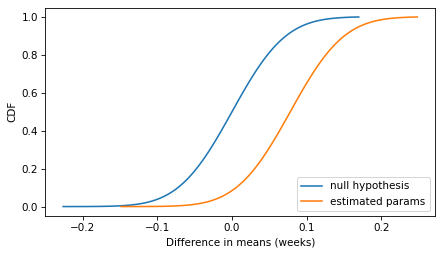

<IPython.core.display.Javascript object>

In [230]:
# Solution

dist_diff_null.plot_cdf(label="null hypothesis")
dist_diff_alt.plot_cdf(label="estimated params")
decorate(xlabel="Difference in means (weeks)", ylabel="CDF", loc="lower right")

**Exercise:** [In a 2014 paper](http://ieeexplore.ieee.org/document/7044435/), Stein et al. investigate the effects of an intervention intended to mitigate gender-stereotypical task allocation within student engineering teams.

Before and after the intervention, students responded to a survey that asked them to rate their contribution to each aspect of class projects on a 7-point scale.

Before the intervention, male students reported higher scores for the programming aspect of the project than female students; on average men reported a score of 3.57 with standard error 0.28. Women reported 1.91, on average, with standard error 0.32.

Compute the sampling distribution of the gender gap (the difference in means), and test whether it is statistically significant.
Because you are given standard errors for the estimated means, you don’t need to know the sample size to figure out the sampling distributions.

After the intervention, the gender gap was smaller: the average score for men was 3.44 (SE 0.16); the average score for women was 3.18 (SE 0.16).
Again, compute the sampling distribution of the gender gap and test it.

Finally, estimate the change in gender gap; what is the sampling distribution of this change, and is it statistically significant?

"Evidence for the persistent effects of an intervention to mitigate gender-stereotypical task allocation within student engineering teams," Proceedings of the IEEE Frontiers in Education Conference, 2014.

In [231]:
# Solution

male_before = Normal(3.57, 0.28**2)
male_after = Normal(3.44, 0.16**2)
female_before = Normal(1.91, 0.32**2)
female_after = Normal(3.18, 0.16**2)

<IPython.core.display.Javascript object>

In [239]:
# Solution


def summarize(dist):
    print("mean, p-value", dist.mu, 1 - dist.cdf(0))
    print("CI", dist.ppf([0.05, 0.95]))
    print("stderr", np.sqrt(dist.sigma2))

<IPython.core.display.Javascript object>

In [242]:
# Solution

diff_before = female_before - male_before
summarize(diff_before)

mean, p-value -1.66 4.7309532320793934e-05
CI [-2.35940136 -0.96059864]
stderr 0.425205832509386


<IPython.core.display.Javascript object>

In [243]:
# Solution

diff_after = female_after - male_after
summarize(diff_after)

mean, p-value -0.2599999999999998 0.1252679872068192
CI [-0.63218789  0.11218789]
stderr 0.2262741699796952


<IPython.core.display.Javascript object>

In [244]:
# Solution

diff = diff_after - diff_before
summarize(diff)

mean, p-value 1.4000000000000001 0.998173051631023
CI [0.60773358 2.19226642]
stderr 0.48166378315169184


<IPython.core.display.Javascript object>

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)